In [10]:
from google.colab import drive
drive.mount("/content/drive/")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
##!rm -rf /content/drive/MyDrive/propaganda_dataset_v2

In [11]:
train_path='/content/drive/MyDrive/propaganda_dataset_v2/propaganda_train.tsv'
valid_path='/content/drive/MyDrive/propaganda_dataset_v2/propaganda_val.tsv'

In [4]:
!nvidia-smi

Thu Mar 23 01:08:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |      0MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.2 MB/s eta 0:00:00


In [15]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys   
     

In [16]:

training_df = pd.read_table(train_path)
valid_df = pd.read_table(valid_path)

In [17]:
training_df.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [18]:
labellist=sorted(list(set(training_df['label'].unique()).union(set(valid_df['label'].unique())))) 

labels={label:i for i,label in enumerate(labellist)}
labels

{'appeal_to_fear_prejudice': 0,
 'causal_oversimplification': 1,
 'doubt': 2,
 'exaggeration,minimisation': 3,
 'flag_waving': 4,
 'loaded_language': 5,
 'name_calling,labeling': 6,
 'not_propaganda': 7,
 'repetition': 8}

Text(0, 0.5, 'Count')

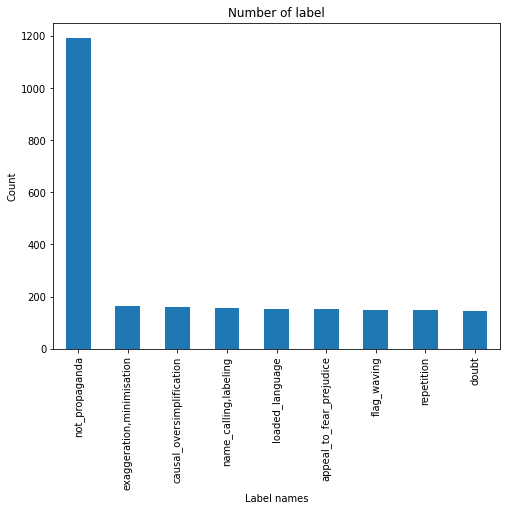

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
training_df['label'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Number of label')
plt.xlabel('Label names')
plt.ylabel('Count')

In [20]:
import torch
import numpy as np
from transformers import BertTokenizer,BertModel, BertForMaskedLM
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,df,column='tagged_in_context'):
        self.labels=[labels[label] for label in df['label']]
        self.texts=[tokenizer(text.lower(),padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df[column]]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self,idx):
        return self.texts[idx]
    
    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)
        
        return batch_texts,batch_y
    

train_data=Dataset(training_df)
test_data=Dataset(valid_df)

In [12]:
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")


GPU acceleration enabled


In [13]:
def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)
  

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
bert = BertModel.from_pretrained('bert-base-uncased').to(device)

for train_input, train_label in train_dataloader:
    input_id, mask, label = prepare_inputs(train_input, train_label, device)
    input_id = input_id.to(device)
    mask = mask.to(device)
    label = label.to(device)
    output = bert(input_ids=input_id, attention_mask=mask, return_dict=False)
    break

print(input_id, mask, label)
print(len(output))
output[1]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[ 101, 2023, 2003,  ...,    0,    0,    0],
        [ 101, 2021, 1051,  ...,    0,    0,    0]], device='cuda:0') tensor([[[1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0]]], device='cuda:0') tensor([1, 2], device='cuda:0')
2


tensor([[-0.6473, -0.4646, -0.9533,  ..., -0.8127, -0.5241,  0.5567],
        [-0.6902, -0.3789, -0.7180,  ..., -0.5118, -0.5204,  0.4499]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [15]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):
    
    def __init__(self, dropout=0.5, num_classes=2, hidden_size=768, num_layers=12, learning_rate=2e-5, batch_size=32, num_epochs=10):
        
        super(BertClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased', hidden_size=hidden_size, num_hidden_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
    
    def forward(self, input_id, mask):
        
        last_hidden_layer, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        
        return final_layer


In [16]:
"""from torch import nn
class BertClassifier(nn.Module):
    
    def __init__(self,dropout=0.5,num_classes=2):
        
        super(BertClassifier,self).__init__()
        
        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()
        
    def forward(self,input_id,mask):
        
        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)
        
        return final_layer
        """

"from torch import nn\nclass BertClassifier(nn.Module):\n    \n    def __init__(self,dropout=0.5,num_classes=2):\n        \n        super(BertClassifier,self).__init__()\n        \n        self.bert=BertModel.from_pretrained('bert-base-uncased')\n        self.dropout=nn.Dropout(dropout)\n        self.linear=nn.Linear(768,num_classes)\n        self.relu=nn.ReLU()\n        \n    def forward(self,input_id,mask):\n        \n        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)\n        dropout_output=self.dropout(pooled_output)\n        linear_output=self.linear(dropout_output)\n        final_layer=self.relu(linear_output)\n        \n        return final_layer\n        "

In [17]:
#we now need a training loop

from torch.optim import Adam
from tqdm import tqdm



def train(model, train_data,val_data,learning_rate,epochs):
    
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=2,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(test_data,batch_size=2)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)
    
    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()
        
    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):
            
            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)
            
            output=model(input_id,mask)
            
            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()
            
            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_acc_val=0
        total_loss_val=0  
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:
                
                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)
                
                output=model(input_id,mask)
                
                batch_loss=criterion(output,val_label.long())
                
                total_loss_val+=batch_loss.item()
                
                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
                
        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        

In [18]:
EPOCHS=2
model=BertClassifier(num_classes=len(labels.keys()))
LR=1e-6


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
train(model,train_data,test_data,LR,EPOCHS)

100%|██████████| 1207/1207 [04:21<00:00,  4.62it/s]


Epochs: 1 | Train Loss: 0.930 | Train Accuracy: 0.466
Val loss: 0.837 | Val Accuracy: 0.519


100%|██████████| 1207/1207 [04:23<00:00,  4.59it/s]


Epochs: 2 | Train Loss: 0.841 | Train Accuracy: 0.493
Val loss: 0.747 | Val Accuracy: 0.519


In [20]:
output_dir="bert-base-uncased-bookclassifier"
torch.save(model,output_dir)
input_dir="bert-base-uncased-bookclassifier"
complete_model=torch.load(input_dir)

In [21]:
batchsize=2
def evaluate(model,test_dataset):
    model.eval()
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)
    
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model=model.cuda()
        
    total_acc_test=0
    with torch.no_grad():
        count=0
        predictions=[]
        for test_input,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_label=test_label.to(device)
            mask=test_input['attention_mask'].to(device)
            input_id=test_input['input_ids'].squeeze(1).to(device)
            output=model(input_id,mask)
            #print(output.argmax(dim=1),test_label)
            predictions.append(output.argmax(dim=1))  #save the prediction for further analysis
            acc=(output.argmax(dim=1)==test_label).sum().item()
            
            total_acc_test+=acc
            if count%100==0:
                print(f'Accuracy so far = {total_acc_test/count: .3f}')
            
    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions

In [22]:
predictions=evaluate(model, test_data)

 18%|█▊        | 52/290 [00:03<00:15, 14.88it/s]

Accuracy so far =  0.500


 35%|███▌      | 102/290 [00:06<00:13, 14.41it/s]

Accuracy so far =  0.510


 52%|█████▏    | 152/290 [00:10<00:09, 14.59it/s]

Accuracy so far =  0.527


 70%|██████▉   | 202/290 [00:13<00:06, 14.55it/s]

Accuracy so far =  0.517


 87%|████████▋ | 252/290 [00:17<00:02, 14.36it/s]

Accuracy so far =  0.516


100%|██████████| 290/290 [00:19<00:00, 14.56it/s]

Test accuracy:  0.519


In [23]:
reverse_index={value:key for (key,value)in labels.items()}

In [ ]:
flattened=[]
for batch in predictions:
    for pred in batch:
        flattened.append(reverse_index[pred.item()])
valid_df['prediction']=flattened
valid_df.head()

LSTM model.

In [21]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional


In [22]:
y=training_df['label']
X=training_df['tagged_in_context']
print(X.shape)
print(y.shape)


(2414,)
(2414,)


In [23]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_len=100  #padding
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [24]:
#Validation data
X_val=valid_df['tagged_in_context']
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_val)
sequences = tokenizer.texts_to_sequences(X_val)
max_len=100  #padding
X_val= pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y_val=valid_df['label']
print(X_val.shape)
print(y_val.shape)

(580, 100)
(580,)


In [25]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# encode labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_val = label_encoder.transform(y_val)

# convert labels to one-hot encoding
y = to_categorical(y, num_classes=9)
y_val = to_categorical(y_val, num_classes=9)


In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(X, y, test_size=0.30, random_state=42)

In [27]:
import tensorflow as tf

In [28]:
print(X_train.shape)
print(y_train.shape)

(1689, 100)
(1689, 9)


In [29]:
print(y_test.shape)
print(X_test.shape)

(725, 9)
(725, 100)


In [30]:
embedding_feature=len(tokenizer.word_index)
embedding_feature
max_features = 10000  # Number of words in the vocabulary
embedding_dim = 128  # Dimension of the word embeddings
lstm_units = 128  # Number of LSTM units
batch_size = 64
epochs = 10
num_labels = 9

In [31]:
'''
max_features = 10000  # Number of words in the vocabulary
embedding_dim = 128  # Dimension of the word embeddings
lstm_units = 128  # Number of LSTM units
batch_size = 64
epochs = 10
num_labels = 9

# Define the model architecture
model = Sequential()
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(num_labels, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()
'''

"\nmax_features = 10000  # Number of words in the vocabulary\nembedding_dim = 128  # Dimension of the word embeddings\nlstm_units = 128  # Number of LSTM units\nbatch_size = 64\nepochs = 10\nnum_labels = 9\n\n# Define the model architecture\nmodel = Sequential()\nmodel.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=max_len))\nmodel.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)))\nmodel.add(Dense(num_labels, activation='softmax'))\n\n# Compile the model\noptimizer = Adam(learning_rate=0.001)\nmodel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])\n\n# Print the model summary\nmodel.summary()\n"

In [33]:

from sklearn.model_selection import StratifiedKFold

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Define the stratified k-fold cross-validator
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Convert the labels to integers
labels = np.argmax(y_train, axis=1)

# Iterate over the folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, labels)):
    print(f'Fold {fold+1}')
    
    # Define the model architecture
    model = Sequential()
    model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_labels, activation='softmax'))
    
    # Compile the model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Extract the training and validation data for the current fold
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    
    # Train the model for the current fold
    model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold), verbose=1)
    
    # Evaluate the model on the test data for the current fold
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test accuracy for fold {fold+1}: {scores[1]*100:.2f}%\n')


Fold 1
Epoch 1/10
22/22 [==============================] - 37s 1s/step - loss: 1.9299 - accuracy: 0.4730 - val_loss: 1.7448 - val_accuracy: 0.4911
Epoch 2/10
22/22 [==============================] - 25s 1s/step - loss: 1.7271 - accuracy: 0.4915 - val_loss: 1.7189 - val_accuracy: 0.4911
Epoch 3/10
22/22 [==============================] - 21s 973ms/step - loss: 1.6809 - accuracy: 0.4915 - val_loss: 1.6812 - val_accuracy: 0.4911
Epoch 4/10
22/22 [==============================] - 24s 1s/step - loss: 1.6122 - accuracy: 0.4930 - val_loss: 1.6494 - val_accuracy: 0.4911
Epoch 5/10
22/22 [==============================] - 22s 989ms/step - loss: 1.4667 - accuracy: 0.5122 - val_loss: 1.6584 - val_accuracy: 0.4793
Epoch 6/10
22/22 [==============================] - 23s 1s/step - loss: 1.2383 - accuracy: 0.5603 - val_loss: 1.6733 - val_accuracy: 0.4734
Epoch 7/10
22/22 [==============================] - 21s 981ms/step - loss: 1.1284 - accuracy: 0.5818 - val_loss: 1.8346 - val_accuracy: 0.4763
Epoc

Test accuracy for fold 1: 44.14%

Fold 2
Epoch 1/10
22/22 [==============================] - 33s 1s/step - loss: 1.9523 - accuracy: 0.4471 - val_loss: 1.7487 - val_accuracy: 0.4911
Epoch 2/10
22/22 [==============================] - 24s 1s/step - loss: 1.7287 - accuracy: 0.4915 - val_loss: 1.7110 - val_accuracy: 0.4911
Epoch 3/10
22/22 [==============================] - 21s 976ms/step - loss: 1.6859 - accuracy: 0.4915 - val_loss: 1.7101 - val_accuracy: 0.4911
Epoch 4/10
22/22 [==============================] - 23s 1s/step - loss: 1.6344 - accuracy: 0.4915 - val_loss: 1.6494 - val_accuracy: 0.4911
Epoch 5/10
22/22 [==============================] - 21s 982ms/step - loss: 1.4782 - accuracy: 0.5174 - val_loss: 1.6364 - val_accuracy: 0.5178
Epoch 6/10
22/22 [==============================] - 23s 1s/step - loss: 1.2817 - accuracy: 0.5522 - val_loss: 1.6682 - val_accuracy: 0.5089
Epoch 7/10
22/22 [==============================] - 20s 927ms/step - loss: 1.1482 - accuracy: 0.5840 - val_loss: 

Test accuracy for fold 2: 42.90%

Fold 3
Epoch 1/10
22/22 [==============================] - 31s 1s/step - loss: 1.9454 - accuracy: 0.4730 - val_loss: 1.7505 - val_accuracy: 0.4911
Epoch 2/10
22/22 [==============================] - 40s 2s/step - loss: 1.7388 - accuracy: 0.4915 - val_loss: 1.7189 - val_accuracy: 0.4911
Epoch 3/10
22/22 [==============================] - 24s 1s/step - loss: 1.6774 - accuracy: 0.4915 - val_loss: 1.6931 - val_accuracy: 0.4911
Epoch 4/10
22/22 [==============================] - 23s 1s/step - loss: 1.5860 - accuracy: 0.4922 - val_loss: 1.6537 - val_accuracy: 0.4941
Epoch 5/10
22/22 [==============================] - 22s 1000ms/step - loss: 1.3877 - accuracy: 0.5285 - val_loss: 1.7957 - val_accuracy: 0.4852
Epoch 6/10
22/22 [==============================] - 24s 1s/step - loss: 1.3689 - accuracy: 0.5514 - val_loss: 1.6744 - val_accuracy: 0.4941
Epoch 7/10
22/22 [==============================] - 23s 1s/step - loss: 1.2151 - accuracy: 0.5596 - val_loss: 1.743

Test accuracy for fold 3: 44.28%

Fold 4
Epoch 1/10
22/22 [==============================] - 30s 1s/step - loss: 1.9461 - accuracy: 0.4700 - val_loss: 1.7553 - val_accuracy: 0.4911
Epoch 2/10
22/22 [==============================] - 24s 1s/step - loss: 1.7277 - accuracy: 0.4915 - val_loss: 1.7297 - val_accuracy: 0.4911
Epoch 3/10
22/22 [==============================] - 22s 1s/step - loss: 1.6883 - accuracy: 0.4915 - val_loss: 1.7133 - val_accuracy: 0.4911
Epoch 4/10
22/22 [==============================] - 24s 1s/step - loss: 1.5939 - accuracy: 0.4944 - val_loss: 1.6922 - val_accuracy: 0.5000
Epoch 5/10
22/22 [==============================] - 21s 972ms/step - loss: 1.4051 - accuracy: 0.5381 - val_loss: 1.7518 - val_accuracy: 0.4497
Epoch 6/10
22/22 [==============================] - 23s 1s/step - loss: 1.2027 - accuracy: 0.5581 - val_loss: 1.8139 - val_accuracy: 0.4734
Epoch 7/10
22/22 [==============================] - 21s 976ms/step - loss: 1.1200 - accuracy: 0.5914 - val_loss: 1.9

Test accuracy for fold 4: 45.52%

Fold 5
Epoch 1/10
22/22 [==============================] - 30s 1s/step - loss: 1.9516 - accuracy: 0.4712 - val_loss: 1.7388 - val_accuracy: 0.4926
Epoch 2/10
22/22 [==============================] - 22s 988ms/step - loss: 1.7339 - accuracy: 0.4911 - val_loss: 1.7098 - val_accuracy: 0.4926
Epoch 3/10
22/22 [==============================] - 24s 1s/step - loss: 1.6764 - accuracy: 0.4911 - val_loss: 1.6776 - val_accuracy: 0.4926
Epoch 4/10
22/22 [==============================] - 21s 983ms/step - loss: 1.5889 - accuracy: 0.4919 - val_loss: 1.6287 - val_accuracy: 0.4926
Epoch 5/10
22/22 [==============================] - 23s 1s/step - loss: 1.3642 - accuracy: 0.5237 - val_loss: 1.8145 - val_accuracy: 0.4243
Epoch 6/10
22/22 [==============================] - 22s 1s/step - loss: 1.2659 - accuracy: 0.5629 - val_loss: 1.6328 - val_accuracy: 0.5074
Epoch 7/10
22/22 [==============================] - 22s 963ms/step - loss: 1.1278 - accuracy: 0.5947 - val_loss: 

In [34]:
###tf.config.run_functions_eagerly(True)

In [35]:
'''
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
										mode="min", patience=5,
										restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128,
					epochs=25, validation_data=(X_val, y_val),
					callbacks=[earlystopping])
					'''

'\nfrom keras import callbacks\nearlystopping = callbacks.EarlyStopping(monitor="val_loss",\n\t\t\t\t\t\t\t\t\t\tmode="min", patience=5,\n\t\t\t\t\t\t\t\t\t\trestore_best_weights=True)\n\nhistory = model.fit(X_train, y_train, batch_size=128,\n\t\t\t\t\tepochs=25, validation_data=(X_val, y_val),\n\t\t\t\t\tcallbacks=[earlystopping])\n\t\t\t\t\t'

In [36]:
prediction= model.predict(X_val)

19/19 [==============================] - 1s 56ms/step


In [37]:
print(prediction)

[[1.19537540e-01 9.67921913e-02 9.53296721e-02 ... 5.46579100e-02
  5.55274673e-02 1.83679715e-01]
 [1.22046247e-01 1.07525632e-01 1.06145270e-01 ... 5.84494323e-02
  4.72834446e-02 1.85361236e-01]
 [9.01603028e-02 7.67467692e-02 9.27408487e-02 ... 6.09543286e-02
  1.26168251e-01 1.69733003e-01]
 ...
 [1.30423449e-03 8.58630752e-04 2.01112847e-03 ... 8.15165229e-04
  9.70877647e-01 6.88784011e-03]
 [2.43146508e-03 1.54244702e-03 2.94219214e-03 ... 9.67130822e-04
  9.55156326e-01 1.08342962e-02]
 [1.20286785e-01 1.10976756e-01 1.11277737e-01 ... 1.38749763e-01
  1.67297516e-02 1.24218941e-01]]


In [38]:
Decode_prediction=np.argmax(prediction,axis=1)

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(training_df['label'])
final_prediction=le.inverse_transform(Decode_prediction)

In [40]:
valid_df['prediction_values']=final_prediction

In [41]:
valid_df=valid_df.reindex(columns=['tagged_in_context','label','prediction_values'])

In [42]:
valid_df

,tagged_in_context,label,prediction_values
0,"On average, between 300 and 600 infections are...",not_propaganda,loaded_language
1,Mostly because <BOS> the country would not las...,causal_oversimplification,repetition
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,appeal_to_fear_prejudice,loaded_language
3,<BOS> You <EOS> may opt out at anytime.,not_propaganda,not_propaganda
4,It must be exacted from him directly in order ...,repetition,"name_calling,labeling"
...,...,...,...
575,"NewsCatholic Church, <BOS> Family, Marriage <E...",not_propaganda,not_propaganda
576,"Remember our saying, modern day fairy <BOS> ta...",not_propaganda,not_propaganda
577,Why <BOS> not <EOS> open up to Iran with massi...,not_propaganda,not_propaganda
578,<BOS> He also sang an Islamic State fight song...,flag_waving,not_propaganda


In [44]:
 valid_df['prediction_values'].nunique()

8